In [48]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

In [49]:
# Get the data
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []

# loop over train_data tuple of type tf.tensor and convert to list with .numpy()
for text,label in train_data:
  training_sentences.append(str(text.numpy()))
  training_labels.append(label.numpy())
  
for text,label in test_data:
  testing_sentences.append(str(text.numpy()))
  testing_labels.append(label.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [50]:
# vocab_size = 10000
embedding_dim = 100
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenize and pad data

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
vocab_size=len(word_index)
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [65]:
#-----------------------------------------------------------
# basic NN with dense layers
# training accuracy = 1 (after 10 epochs)
# validation accuracy = 0.83 (after 10 epochs) decreasing with epochs
# validation loss increasing with epochs --> overfitting
#-----------------------------------------------------------

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#-----------------------------------------------------------
# multi-layer LSTM 
# training accuracy = 1 (after 10 epochs)
# validation accuracy = 0.82 (after 10 epochs) slight decrease with epochs
# validation loss increasing with epochs --> overfitting
#-----------------------------------------------------------

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, 64),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

#-----------------------------------------------------------
# single-layer LSTM with dropout layer and custom optimizer according to original dropout paper
# N. Srivastava, J. Mach. Learn. Res. 15 (2014) 1929-1958
# training accuracy = 0.94 (after 10 epochs)
# validation accuracy = 0.83 (after 10 epochs)
# validation loss decreasing with epochs (up to 5 epochs) --> NOT overfitting
# validation loss increases after 5 epochs, suggesting early stoppage at 5 to avoid overfitting beyond this
#-----------------------------------------------------------

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# -----------------------------------------------------------
# single-layer LSTM, convolution 1D layer, with dropout layers and custom optimizer 
# -----------------------------------------------------------

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, 64),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv1D(64, 5, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

#-----------------------------------------------------------
# multi-layer LSTM, with dropout layers and custom optimizer 
#-----------------------------------------------------------

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, 64),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

In [66]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 30s 38ms/step - loss: 0.4526 - accuracy: 0.7759 - val_loss: 0.3710 - val_accuracy: 0.8348
Epoch 2/10
782/782 [==============================] - 30s 38ms/step - loss: 0.1315 - accuracy: 0.9529 - val_loss: 0.4953 - val_accuracy: 0.8058
Epoch 3/10
782/782 [==============================] - 30s 39ms/step - loss: 0.0097 - accuracy: 0.9974 - val_loss: 0.7035 - val_accuracy: 0.8070
Epoch 4/10
782/782 [==============================] - 30s 39ms/step - loss: 4.9562e-04 - accuracy: 0.9999 - val_loss: 0.9160 - val_accuracy: 0.8112
Epoch 5/10
782/782 [==============================] - 30s 38ms/step - loss: 2.1399e-06 - accuracy: 1.0000 - val_loss: 1.0971 - val_accuracy: 0.8144
Epoch 6/10
782/782 [==============================] - 30s 39ms/step - loss: 1.9474e-08 - accuracy: 1.0000 - val_loss: 1.1517 - val_accuracy: 0.8144
Epoch 7/10
782/782 [==============================] - 30s 38ms/step - loss: 4.3162e-09 - accuracy: 1.0000 - val_loss: 1.1754

In [68]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title('Basic NN')
  plt.show()

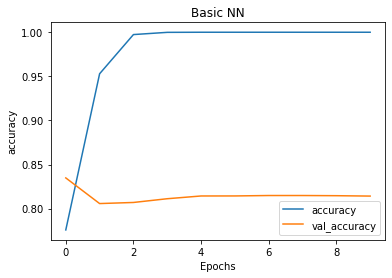

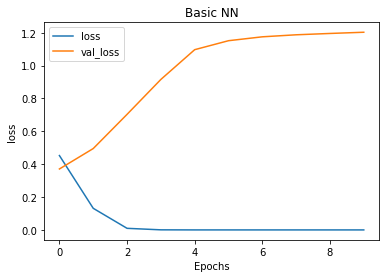

In [69]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')